<a href="https://colab.research.google.com/github/bmontoyag/UTEC_IA_Fundamentals/blob/main/Proyecto_final/Experimento_modelo_referencia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Instalar la biblioteca KaggleHub para interactuar con Kaggle
!pip install -q kagglehub

# Importar las bibliotecas necesarias para la gestión de archivos
import kagglehub
import os

# Descargar el dataset. 'data_dir' contendrá la ruta a la carpeta raíz descargada.
print("Descargando el dataset desde KaggleHub...")
data_dir = kagglehub.dataset_download("muhammadardiputra/potato-leaf-disease-dataset")
print(f"Dataset descargado en: {data_dir}")

# Verificamos el contenido para asegurarnos de la estructura de carpetas
# Esto nos ayuda a construir la ruta completa y correcta en el siguiente paso
print("Contenido de la carpeta descargada:", os.listdir(data_dir))

Descargando el dataset desde KaggleHub...


100%|██████████| 25.2M/25.2M [00:00<00:00, 75.6MB/s]

Extracting files...


Dataset descargado en: /root/.cache/kagglehub/datasets/muhammadardiputra/potato-leaf-disease-dataset/versions/1
Contenido de la carpeta descargada: ['Potato']


In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

# --- Parámetros para el procesamiento y entrenamiento ---
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 15

# --- Construir la ruta completa al directorio que contiene Train/Test ---
# Basado en la inspección anterior, añadimos el nombre de la subcarpeta
data_dir_full = os.path.join(data_dir, "Potato")

# --- Cargar los datos de entrenamiento y validación (80/20) ---
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(data_dir_full, "Train"),
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="both",
    seed=123
)
train_dataset, validation_dataset = dataset

# --- Cargar los datos de prueba ---
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(data_dir_full, "Test"),
    shuffle=False,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

# Guardar los nombres de las clases (enfermedades)
class_names = train_dataset.class_names
print("\nClases detectadas:", class_names)

# --- Optimización del rendimiento del dataset ---
# Normaliza los valores de los píxeles al rango [0, 1] y usa caché para acelerar la carga
def normalize(image, label):
    image = tf.cast(image / 255.0, tf.float32)
    return image, label

train_dataset = train_dataset.map(normalize).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.map(normalize).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(normalize).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

print("\n¡Datos listos para el entrenamiento!")

Found 900 files belonging to 3 classes.
Using 720 files for training.
Using 180 files for validation.
Found 300 files belonging to 3 classes.

Clases detectadas: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

¡Datos listos para el entrenamiento!


In [ ]:
# Capa para aplicar transformaciones aleatorias a las imágenes y evitar sobreajuste
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

# --- Construcción de la Arquitectura del Modelo CNN ---
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
num_classes = len(class_names)

model = models.Sequential([
    layers.InputLayer(input_shape=input_shape),
    data_augmentation,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Capa para regularización
    layers.Dense(num_classes, activation='softmax')
])

# --- Compilar el modelo con un optimizador, función de pérdida y métricas ---
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Muestra un resumen de la arquitectura del modelo
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    16,777,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,870,979 (64.36 MB)

 Trainable params: 16,870,979 (64.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print("\nIniciando el entrenamiento del modelo...")

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=validation_dataset,
    verbose=1,
)

print("\n Entrenamiento completado.")


Iniciando el entrenamiento del modelo...
Epoch 1/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 120s 5s/step - accuracy: 0.3936 - loss: 1.5970 - val_accuracy: 0.4944 - val_loss: 0.8570
Epoch 2/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 115s 5s/step - accuracy: 0.6843 - loss: 0.6710 - val_accuracy: 0.8389 - val_loss: 0.3929
Epoch 3/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 114s 5s/step - accuracy: 0.8430 - loss: 0.4366 - val_accuracy: 0.8722 - val_loss: 0.3170
Epoch 4/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 115s 5s/step - accuracy: 0.8513 - loss: 0.3598 - val_accuracy: 0.8722 - val_loss: 0.3954
Epoch 5/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 115s 5s/step - accuracy: 0.8479 - loss: 0.3834 - val_accuracy: 0.9167 - val_loss: 0.2213
Epoch 6/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 115s 5s/step - accuracy: 0.8782 - loss: 0.3328 - val_accuracy: 0.9222 - val_loss: 0.2158
Epoch 7/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 114s 5s/step - accuracy: 0.9100 - loss: 0.2727 - val_accuracy: 0.8389 - val_loss: 0.3567
Epoch 8/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 114s 5s/step - accuracy: 0.8632

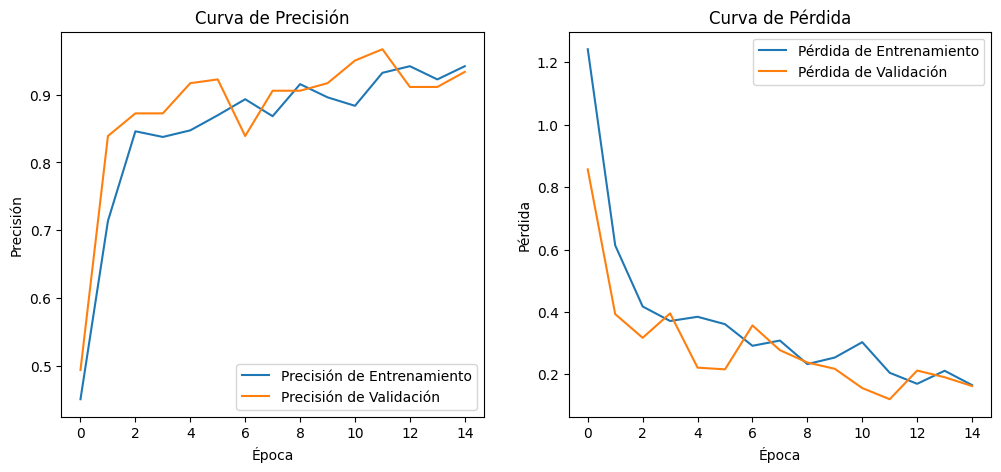


Evaluando el modelo con los datos de prueba...
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.9629 - loss: 0.1238

 Precisión final en el conjunto de prueba: 96.00%


In [ ]:
# --- Gráficas de Precisión y Pérdida durante el entrenamiento ---
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Precisión de Entrenamiento')
plt.plot(range(EPOCHS), val_acc, label='Precisión de Validación')
plt.legend(loc='lower right')
plt.title('Curva de Precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Pérdida de Entrenamiento')
plt.plot(range(EPOCHS), val_loss, label='Pérdida de Validación')
plt.legend(loc='upper right')
plt.title('Curva de Pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.show()

# --- Evaluación final con el conjunto de prueba ---
print("\nEvaluando el modelo con los datos de prueba...")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"\n Precisión final en el conjunto de prueba: {test_acc*100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


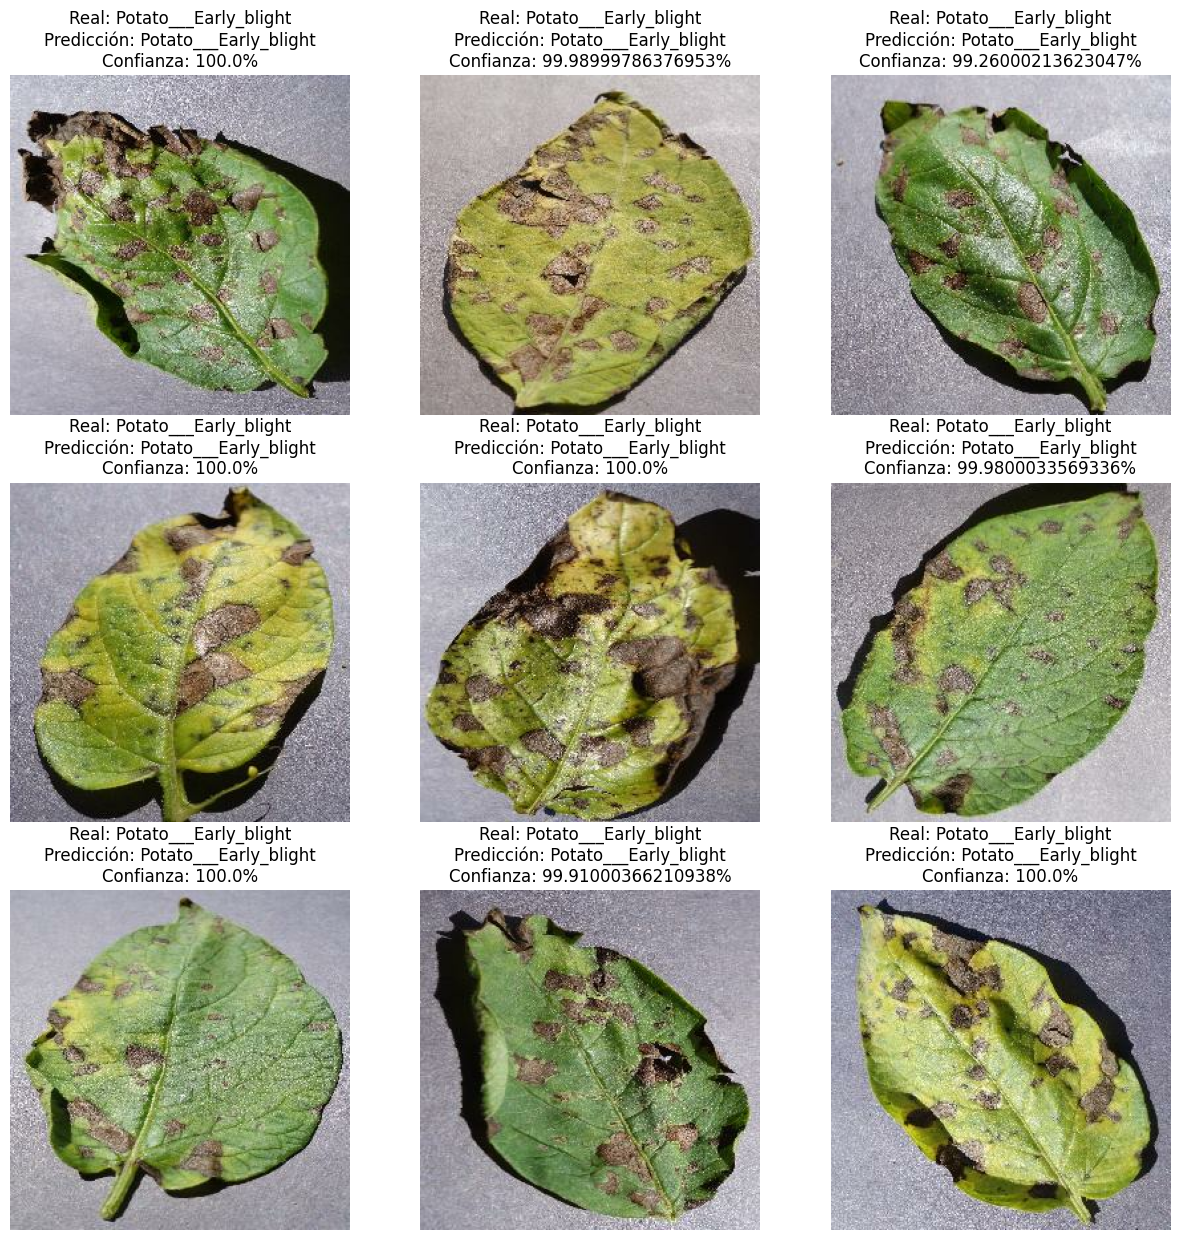

In [ ]:
import numpy as np

# --- Función para predecir una sola imagen ---
def predict_image(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Crear un lote de una sola imagen

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

# --- Visualizar predicciones en un conjunto de imágenes de prueba ---
plt.figure(figsize=(15, 15))
for images, labels in test_dataset.take(1):
    for i in range(9):  # Mostramos las primeras 9 imágenes
        ax = plt.subplot(3, 3, i + 1)
        # Unnormalize images before displaying
        plt.imshow((images[i].numpy() * 255).astype("uint8"))

        predicted_class, confidence = predict_image(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Real: {actual_class}\nPredicción: {predicted_class}\nConfianza: {confidence}%")
        plt.axis("off")